<a href="https://colab.research.google.com/github/steinruck/data603-sp22/blob/project-submission/final-project/final_sparknlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# this is to get sparknlp running in colab
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2022-05-10 23:49:38--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2022-05-10 23:49:38--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2022-05-10 23:49:38--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:44

In [4]:
# start sparknlp session
import sparknlp
from sparknlp import DocumentAssembler
from sparknlp.annotator import SentenceDetector
from sparknlp.annotator import Tokenizer
from pyspark.ml import Pipeline

spark = sparknlp.start()

print("Spark NLP version: {}".format(sparknlp.version()))
print("Apache Spark version: {}".format(spark.version))

Spark NLP version: 3.4.4
Apache Spark version: 3.0.3


In [77]:
from pyspark.sql.functions import col, regexp_replace, concat_ws, split, collect_list, explode, size, expr, array_contains, udf
from pyspark.ml.feature import StopWordsRemover, CountVectorizer, IDF
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.clustering import LDA

In [6]:
# load dataset
# starts as 7 rows; one for each book
data = spark.read.csv('/content/drive/Shareddrives/Project/submission/books_6_rows.csv', header='true')

In [7]:
data.show()

+--------------------+--------------------+
|                text|              titles|
+--------------------+--------------------+
| the boy who live...|The Philosophers ...|
| . . l harry pott...|The Chamber of Se...|
| owl post harry p...|The Prisoner of A...|
| the riddle house...|  The Goblet of Fire|
|harry potter dudl...|The Order of the ...|
| the other minist...|The Half-Blood Pr...|
|i the dark lord a...| The Deathly Hallows|
+--------------------+--------------------+



You can see above there are only 7 observations in this dataset. One for each book in the series. There are also some formatting errors, as well as extra characters. 


In [8]:
data.count()

7

In [9]:
# there are only two columns, both strings
data.printSchema()

root
 |-- text: string (nullable = true)
 |-- titles: string (nullable = true)



## Spark NLP
This library from John Snow Labs includes many conventional Natural Language Processing options as well as a great number of pretrained models for a variety of purposes. If everything had gone to plan, I would have used pretrained models for lemmatization, named entity recognition, and others. However, running any pretrained model in Colab caused it to run out of ram, and any attempts to get a working environment using Databricks and a local Spark installation led to dependency issues I couldn't resolve. Instead, I will conduct some pre-processing and data cleaning using spark before moving into pandas and sklearn for modeling and prediction. 

---

The first step is to make sure the data is in the format needed for annotators to use. In `sparknlp`, annotators can be either estimators or transformers, similar to Spark ML. There are two types of annotators: AnnotatorApproach and AnnotatorModel. AnnotatorApproach methods require a `transform()`, and AnnotatorModel methods require a `fit()` and a `transform()`.

### DocumentAssembler
>Transformers are used to convert a dataframe from one annotator type to the other. DocumentAssembler is one of these. This transformer annotates the raw data so that it is in the right format for other annotators to use. 

### SentenceDetector
>The newly created 'document' column is fed into the SentenceDetector which creates an array of sentences and a new column called 'sentences'. In this case, the array is exploded so each sentence becomes a new line. 

### Tokenizer
>Tokenizer is an annotator that transforms the DataFrame without using a pretrained model. It is used to convert strings into arrays of sentences with identifying metadata. It is of the AnnotatorModel type. 

### Pipeline
> Spark NLP interacts with Spark ML via an API. All Spark annotators and transformers can be used in a pipeline. Each of the above can be run in sequence, passing the output as input to the next. 

In [10]:
# use DocumentAssembler on dataframe, input is the text column, output is document
# id is the title of the book so each sentence remains connected to the book
document_assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('document')\
    .setIdCol('titles')

# use SentenceDetector on document column, output sentence column - recognizes sentences
# explode set to true (makes each sentence its own line)
sent_detector = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentences')\
    .setExplodeSentences(True)

# use Tokenizer for word tokenization
tokenizer = Tokenizer()\
    .setInputCols(['sentences'])\
    .setOutputCol('tokens')

# set the stages of the pipeline
pipeline = Pipeline(stages=[
    document_assembler,
    sent_detector,
    tokenizer                         
])

# fit and transform 
pipeline_model = pipeline.fit(data).transform(data)

In [11]:
# the output of the pipeline is a dataframe. It doesn't provide much use at first glance
pipeline_model.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|              titles|            document|           sentences|              tokens|
+--------------------+--------------------+--------------------+--------------------+--------------------+
| the boy who live...|The Philosophers ...|[[document, 0, 41...|[[document, 1, 13...|[[token, 1, 3, th...|
| the boy who live...|The Philosophers ...|[[document, 0, 41...|[[document, 139, ...|[[token, 139, 142...|
| the boy who live...|The Philosophers ...|[[document, 0, 41...|[[document, 273, ...|[[token, 273, 274...|
| the boy who live...|The Philosophers ...|[[document, 0, 41...|[[document, 346, ...|[[token, 346, 347...|
| the boy who live...|The Philosophers ...|[[document, 0, 41...|[[document, 430, ...|[[token, 430, 432...|
| the boy who live...|The Philosophers ...|[[document, 0, 41...|[[document, 620, ...|[[token, 620, 622...|
| the boy who live...|The Philosopher

In [12]:
# data can be extracted, such as the first sentence of the first document and its metadata
pipeline_model.first()['sentences'][0].asDict()

{'annotatorType': 'document',
 'begin': 1,
 'embeddings': [],
 'end': 137,
 'metadata': {'sentence': '0'},
 'result': 'the boy who lived mr. and mrs. dursley of number four privet drive were proud to say that they were perfectly normal thank you very much.'}

In [13]:
# the schema of the original dataframe has changed
# there are now 5 columns, with document, sentences, and tokens being arrays created in the pipeline
pipeline_model.printSchema()

root
 |-- text: string (nullable = true)
 |-- titles: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentences: array (nullable = false)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |--

In [14]:
pipeline_model.count()

84981

This is where I would use a pretrained model like `DistilBertEmbeddings()`, `NerDLModel.pretrained()`, to do some Named Entity recognition, or to do lemmatization. Since I couldn't get compute resources to cooperate, I will instead use Spark and Spark ML to do some further analysis. 

___

In [15]:
# create a dataframe containing the title, sentence, and words
df = pipeline_model.withColumn('sentence', pipeline_model.sentences['result'])
df = df.withColumn('words', df.tokens['result'])

df = df.select(df['titles'], df['sentence'], df['words'])
df.show()

+--------------------+--------------------+--------------------+
|              titles|            sentence|               words|
+--------------------+--------------------+--------------------+
|The Philosophers ...|[the boy who live...|[the, boy, who, l...|
|The Philosophers ...|[they were the la...|[they, were, the,...|
|The Philosophers ...|[mr. dursley was ...|[mr, ., dursley, ...|
|The Philosophers ...|[he was big beefy...|[he, was, big, be...|
|The Philosophers ...|[mrs. dursley was...|[mrs, ., dursley,...|
|The Philosophers ...|[the dursley had ...|[the, dursley, ha...|
|The Philosophers ...|[the dursleys had...|[the, dursleys, h...|
|The Philosophers ...|[they didn think ...|[they, didn, thin...|
|The Philosophers ...|[mrs. potter was ...|[mrs, ., potter, ...|
|The Philosophers ...|[the dursleys shu...|[the, dursleys, s...|
|The Philosophers ...|[the dursleys kne...|[the, dursleys, k...|
|The Philosophers ...|[this boy was ano...|[this, boy, was, ...|
|The Philosophers ...|[wh

In [16]:
# count number of sentences per book
sent_count = df.withColumn('book', col('titles'))\
    .groupBy('book')\
    .count()\
    .sort('count')

sent_count.show(truncate=False)

+------------------------+-----+
|book                    |count|
+------------------------+-----+
|The Philosophers Stone  |6022 |
|The Chamber of Secrets  |6610 |
|The Prisoner of Azkaban |9663 |
|The Half-Blood Prince   |13039|
|The Deathly Hallows     |13794|
|The Goblet of Fire      |16532|
|The Order of the Phoenix|19321|
+------------------------+-----+



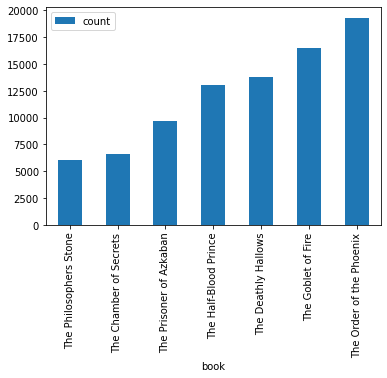

In [18]:
sent_count = sent_count.toPandas()
sent_count.plot.bar(x='book', y='count')

The Order of the Phoenix has the most sentences at 19320, The Philosopher's Stone has the fewest at 6023. This is a little innacurate because I don't know what extra stuff might be in the .txt files I used as my data. 

__

Next I am going to remove stop words and get some more counts, as well as do some character mapping. Stop word list from: https://www.ranks.nl/stopwords 

In [19]:
stop_words = ['a', 'able', 'about', 'above', 'abst', 'accordance', 'according', 'accordingly', 'across', 
              'act', 'actually', 'added', 'adj', 'affected', 'affecting', 'affects', 'after', 'afterwards', 
              'again', 'against', 'ah', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 
              'always', 'am', 'among', 'amongst', 'an', 'and', 'announce', 'another', 'any', 'anybody', 
              'anyhow', 'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apparently', 
              'approximately', 'are', 'aren', 'arent', 'arise', 'around', 'as', 'aside', 'ask', 'asking', 
              'at', 'auth', 'available', 'away', 'awfully', 'b', 'back', 'be', 'became', 'because', 'become', 
              'becomes', 'becoming', 'been', 'before', 'beforehand', 'begin', 'beginning', 'beginnings', 
              'begins', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'between', 'beyond', 
              'biol', 'both', 'brief', 'briefly', 'but', 'by', 'c', 'ca', 'came', 'can', 'cannot', "can't", 
              'cause', 'causes', 'certain', 'certainly', 'co', 'com', 'come', 'comes', 'contain', 'containing', 
              'contains', 'could', 'couldnt', 'd', 'date', 'did', "didn't", 'different', 'do', 'does', "doesn't", 
              'doing', 'done', "don't", 'down', 'downwards', 'due', 'during', 'e', 'each', 'ed', 'edu', 'effect', 
              'eg', 'eight', 'eighty', 'either', 'else', 'elsewhere', 'end', 'ending', 'enough', 'especially', 
              'et', 'et-al', 'etc', 'even', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 
              'ex', 'except', 'f', 'far', 'few', 'ff', 'fifth', 'first', 'five', 'fix', 'followed', 'following', 
              'follows', 'for', 'former', 'formerly', 'forth', 'found', 'four', 'from', 'further', 'furthermore', 
              'g', 'gave', 'get', 'gets', 'getting', 'give', 'given', 'gives', 'giving', 'go', 'goes', 'gone', 
              'got', 'gotten', 'h', 'had', 'happens', 'hardly', 'has', "hasn't", 'have', "haven't", 'having', 
              'he', 'hed', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'heres', 'hereupon', 'hers', 
              'herself', 'hes', 'hi', 'hid', 'him', 'himself', 'his', 'hither', 'home', 'how', 'howbeit', 'however', 
              'hundred', 'i', 'id', 'ie', 'if', "i'll", 'im', 'immediate', 'immediately', 'importance', 'important', 
              'in', 'inc', 'indeed', 'index', 'information', 'instead', 'into', 'invention', 'inward', 'is', "isn't", 
              'it', 'itd', "it'll", 'its', 'itself', "i've", 'j', 'just', 'k', 'keep', 'keeps', 'kept', 'kg', 'km', 
              'know', 'known', 'knows', 'l', 'largely', 'last', 'lately', 'later', 'latter', 'latterly', 'least', 
              'less', 'lest', 'let', 'lets', 'like', 'liked', 'likely', 'line', 'little', "'ll", 'look', 'looking', 
              'looks', 'ltd', 'm', 'made', 'mainly', 'make', 'makes', 'many', 'may', 'maybe', 'me', 'mean', 'means', 
              'meantime', 'meanwhile', 'merely', 'mg', 'might', 'million', 'miss', 'ml', 'more', 'moreover', 'most', 
              'mostly', 'mr', 'mrs', 'much', 'mug', 'must', 'my', 'myself', 'n', 'na', 'name', 'namely', 'nay', 'nd', 
              'near', 'nearly', 'necessarily', 'necessary', 'need', 'needs', 'neither', 'never', 'nevertheless', 
              'new', 'next', 'nine', 'ninety', 'no', 'nobody', 'non', 'none', 'nonetheless', 'noone', 'nor', 
              'normally', 'nos', 'not', 'noted', 'nothing', 'now', 'nowhere', 'o', 'obtain', 'obtained', 'obviously', 
              'of', 'off', 'often', 'oh', 'ok', 'okay', 'old', 'omitted', 'on', 'once', 'one', 'ones', 'only', 'onto', 
              'or', 'ord', 'other', 'others', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'outside', 
              'over', 'overall', 'owing', 'own', 'p', 'page', 'pages', 'part', 'particular', 'particularly', 'past', 
              'per', 'perhaps', 'placed', 'please', 'plus', 'poorly', 'possible', 'possibly', 'potentially', 'pp', 
              'predominantly', 'present', 'previously', 'primarily', 'probably', 'promptly', 'proud', 'provides', 
              'put', 'q', 'que', 'quickly', 'quite', 'qv', 'r', 'ran', 'rather', 'rd', 're', 'readily', 'really', 
              'recent', 'recently', 'ref', 'refs', 'regarding', 'regardless', 'regards', 'related', 'relatively', 
              'research', 'respectively', 'resulted', 'resulting', 'results', 'right', 'run', 's', 'said', 'same', 
              'saw', 'say', 'saying', 'says', 'sec', 'section', 'see', 'seeing', 'seem', 'seemed', 'seeming', 
              'seems', 'seen', 'self', 'selves', 'sent', 'seven', 'several', 'shall', 'she', 'shed', "she'll", 
              'shes', 'should', "shouldn't", 'show', 'showed', 'shown', 'showns', 'shows', 'significant', 
              'significantly', 'similar', 'similarly', 'since', 'six', 'slightly', 'so', 'some', 'somebody', 
              'somehow', 'someone', 'somethan', 'something', 'sometime', 'sometimes', 'somewhat', 'somewhere', 
              'soon', 'sorry', 'specifically', 'specified', 'specify', 'specifying', 'still', 'stop', 'strongly', 
              'sub', 'substantially', 'successfully', 'such', 'sufficiently', 'suggest', 'sup', 'sure', 't', 
              'take', 'taken', 'taking', 'tell', 'tends', 'th', 'than', 'thank', 'thanks', 'thanx', 'that', 
              "that'll", 'thats', "that've", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 
              'there', 'thereafter', 'thereby', 'thered', 'therefore', 'therein', "there'll", 'thereof', 
              'therere', 'theres', 'thereto', 'thereupon', "there've", 'these', 'they', 'theyd', "they'll", 
              'theyre', "they've", 'think', 'this', 'those', 'thou', 'though', 'thoughh', 'thousand', 'throug', 
              'through', 'throughout', 'thru', 'thus', 'til', 'tip', 'to', 'together', 'too', 'took', 'toward', 
              'towards', 'tried', 'tries', 'truly', 'try', 'trying', 'ts', 'twice', 'two', 'u', 'un', 'under', 
              'unfortunately', 'unless', 'unlike', 'unlikely', 'until', 'unto', 'up', 'upon', 'ups', 'us', 'use', 
              'used', 'useful', 'usefully', 'usefulness', 'uses', 'using', 'usually', 'v', 'value', 'various', 
              "'ve", 'very', 'via', 'viz', 'vol', 'vols', 'vs', 'w', 'want', 'wants', 'was', 'wasnt', 'way', 
              'we', 'wed', 'welcome', "we'll", 'went', 'were', 'werent', "we've", 'what', 'whatever', "what'll", 
              'whats', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 
              'wheres', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whim', 'whither', 'who', 'whod', 
              'whoever', 'whole', "who'll", 'whom', 'whomever', 'whos', 'whose', 'why', 'widely', 'willing', 
              'wish', 'with', 'within', 'without', 'wont', 'words', 'world', 'would', 'wouldnt', 'www', 'x', 
              'y', 'yes', 'yet', 'you', 'youd', "you'll", 'your', 'youre', 'yours', 'yourself', 'yourselves', 
              "you've", 'z', 'zero', 'rowling', 've', 'll', '', ' ']

In [20]:
remover = StopWordsRemover(inputCol='words', outputCol='no_stop', stopWords=stop_words)

no_stop = remover.transform(df)

no_stop.show()

+--------------------+--------------------+--------------------+--------------------+
|              titles|            sentence|               words|             no_stop|
+--------------------+--------------------+--------------------+--------------------+
|The Philosophers ...|[the boy who live...|[the, boy, who, l...|[boy, lived, ., ....|
|The Philosophers ...|[they were the la...|[they, were, the,...|[people, expect, ...|
|The Philosophers ...|[mr. dursley was ...|[mr, ., dursley, ...|[., dursley, dire...|
|The Philosophers ...|[he was big beefy...|[he, was, big, be...|[big, beefy, man,...|
|The Philosophers ...|[mrs. dursley was...|[mrs, ., dursley,...|[., dursley, thin...|
|The Philosophers ...|[the dursley had ...|[the, dursley, ha...|[dursley, small, ...|
|The Philosophers ...|[the dursleys had...|[the, dursleys, h...|[dursleys, wanted...|
|The Philosophers ...|[they didn think ...|[they, didn, thin...|[didn, bear, pott...|
|The Philosophers ...|[mrs. potter was ...|[mrs, ., po

I'm sure there's a better way, but since I'm using the output of sparknlp I can't just change one and have the rest be fine. I want to remove the rest of the punctuation and single letters from the dataset, so I am going to join the 'no_stop' column, remove punctuation and single letters, and then split again. 

In [21]:
# make each row a single string instead of list
no_stop = no_stop.withColumn("clean", concat_ws(",", "no_stop"))

# remove special characters
no_stop = no_stop.withColumn('clean', regexp_replace(no_stop['clean'], "[^0-9a-zA-Z]+", ' '))

# remove single letters
no_stop = no_stop.withColumn('clean', regexp_replace(no_stop['clean'], "\s+[a-zA-Z]\s+", ' '))

# delete extra spaces
no_stop = no_stop.withColumn('clean', regexp_replace(no_stop['clean'],"\s+", ' ' ))

# split sentences back to words on space
no_stop = no_stop.withColumn('clean', split(col("clean")," "))

no_stop.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|              titles|            sentence|               words|             no_stop|               clean|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|The Philosophers ...|[the boy who live...|[the, boy, who, l...|[boy, lived, ., ....|[boy, lived, durs...|
|The Philosophers ...|[they were the la...|[they, were, the,...|[people, expect, ...|[people, expect, ...|
|The Philosophers ...|[mr. dursley was ...|[mr, ., dursley, ...|[., dursley, dire...|[, dursley, direc...|
|The Philosophers ...|[he was big beefy...|[he, was, big, be...|[big, beefy, man,...|[big, beefy, man,...|
|The Philosophers ...|[mrs. dursley was...|[mrs, ., dursley,...|[., dursley, thin...|[, dursley, thin,...|
|The Philosophers ...|[the dursley had ...|[the, dursley, ha...|[dursley, small, ...|[dursley, small, ...|
|The Philosophers ...|[the dursleys h

In [22]:
print(no_stop.first()['clean'])

['boy', 'lived', 'dursley', 'number', 'privet', 'drive', 'perfectly', 'normal', '']


From here I would like to get some more counts about various aspects of each book. To do this, I need to group by book. I am going to create one for total word count including stop words, and one without stop words to compare.

In [23]:
books = no_stop.withColumn('words', explode('clean'))
books = books.groupBy('titles').agg(collect_list('words').alias('words'))
books.show()

+--------------------+--------------------+
|              titles|               words|
+--------------------+--------------------+
|  The Goblet of Fire|[riddle, house, v...|
|The Half-Blood Pr...|[minister, nearin...|
|The Order of the ...|[harry, potter, d...|
|The Philosophers ...|[boy, lived, durs...|
|The Prisoner of A...|[owl, post, harry...|
|The Chamber of Se...|[, , , , harry, p...|
| The Deathly Hallows|[dark, lord, asce...|
+--------------------+--------------------+



In [24]:
books_s = no_stop.withColumn('words', explode('words'))
books_s = books_s.groupBy('titles').agg(collect_list('words').alias('words'))
books_s.show()

+--------------------+--------------------+
|              titles|               words|
+--------------------+--------------------+
|  The Goblet of Fire|[the, riddle, hou...|
|The Half-Blood Pr...|[the, other, mini...|
|The Order of the ...|[harry, potter, d...|
|The Philosophers ...|[the, boy, who, l...|
|The Prisoner of A...|[owl, post, harry...|
|The Chamber of Se...|[., ., l, harry, ...|
| The Deathly Hallows|[i, the, dark, lo...|
+--------------------+--------------------+



In [25]:
books = books.withColumn('word_count', size('words'))
books.show()

+--------------------+--------------------+----------+
|              titles|               words|word_count|
+--------------------+--------------------+----------+
|  The Goblet of Fire|[riddle, house, v...|    102409|
|The Half-Blood Pr...|[minister, nearin...|     84570|
|The Order of the ...|[harry, potter, d...|    129210|
|The Philosophers ...|[boy, lived, durs...|     38207|
|The Prisoner of A...|[owl, post, harry...|     57805|
|The Chamber of Se...|[, , , , harry, p...|     44230|
| The Deathly Hallows|[dark, lord, asce...|     96964|
+--------------------+--------------------+----------+



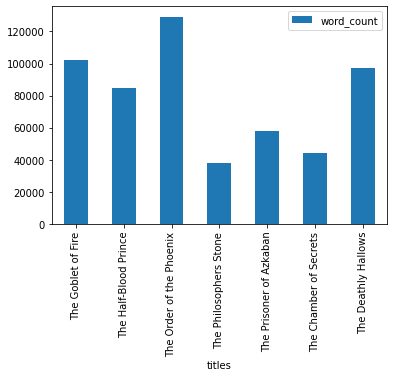

In [26]:
word_count = books.toPandas()
word_count.plot.bar(x='titles', y='word_count')

In [27]:
books_s = books_s.withColumn('word_count', size('words'))
books_s.show()

+--------------------+--------------------+----------+
|              titles|               words|word_count|
+--------------------+--------------------+----------+
|  The Goblet of Fire|[the, riddle, hou...|    208689|
|The Half-Blood Pr...|[the, other, mini...|    178354|
|The Order of the ...|[harry, potter, d...|    271834|
|The Philosophers ...|[the, boy, who, l...|     81808|
|The Prisoner of A...|[owl, post, harry...|    114701|
|The Chamber of Se...|[., ., l, harry, ...|     90242|
| The Deathly Hallows|[i, the, dark, lo...|    208408|
+--------------------+--------------------+----------+



Before removing stop words and single letters (even though there still appear to be some in there), there are almost 150k more words in The Order of the Phoenix than without. There are about 43k more words in the Philosoper's Stone before removing stop words. These counts are of unique words. 

In [28]:
unique_words = books.withColumn('word', explode(col('words')))\
    .groupBy('titles', 'word')\
    .count()\
    .sort('count', ascending=False)

In [31]:
unique_words = unique_words.filter(unique_words.word != '')
unique_words.show(50)

+--------------------+----------+-----+
|              titles|      word|count|
+--------------------+----------+-----+
|The Order of the ...|     harry| 4092|
|  The Goblet of Fire|     harry| 3598|
| The Deathly Hallows|     harry| 3193|
|The Half-Blood Pr...|     harry| 2789|
|The Prisoner of A...|     harry| 2049|
|The Chamber of Se...|     harry| 1658|
|The Philosophers ...|     harry| 1325|
|The Order of the ...|       ron| 1307|
|The Order of the ...|  hermione| 1307|
| The Deathly Hallows|  hermione| 1224|
| The Deathly Hallows|       ron| 1176|
|  The Goblet of Fire|       ron| 1043|
|The Half-Blood Pr...|dumbledore| 1034|
|The Half-Blood Pr...|       ron|  877|
|  The Goblet of Fire|  hermione|  871|
|The Prisoner of A...|       ron|  791|
|The Chamber of Se...|       ron|  706|
|The Half-Blood Pr...|  hermione|  694|
|The Prisoner of A...|  hermione|  672|
|  The Goblet of Fire|    potter|  664|
|The Order of the ...|      well|  664|
|The Order of the ...|dumbledore|  661|


These are the most common words in the entire series grouped by book, then word, and then sorted on count. There are still some empty strings in there even after all the processing, so I filtered those out. Overall, some of the most common words are harry, ron, hermione, dumbledore, professor, and hagrid. I could go back to the stop words removal and add some words to the list to remove them (ie said, page, k, rowling, like, s, just, did, ve, got, etc), but for now they can stay. 

In [40]:
characters = unique_words.filter((unique_words.word == 'harry') | (unique_words.word == 'ron') | (unique_words.word == 'hermione') | (unique_words.word == 'dumbledore') | (unique_words.word == 'voldemort'))\
    .sort('titles', 'count')
characters.show(35)

+--------------------+----------+-----+
|              titles|      word|count|
+--------------------+----------+-----+
|The Chamber of Se...| voldemort|   25|
|The Chamber of Se...|dumbledore|  159|
|The Chamber of Se...|  hermione|  320|
|The Chamber of Se...|       ron|  706|
|The Chamber of Se...|     harry| 1658|
| The Deathly Hallows| voldemort|  446|
| The Deathly Hallows|dumbledore|  589|
| The Deathly Hallows|       ron| 1176|
| The Deathly Hallows|  hermione| 1224|
| The Deathly Hallows|     harry| 3193|
|  The Goblet of Fire| voldemort|  237|
|  The Goblet of Fire|dumbledore|  599|
|  The Goblet of Fire|  hermione|  871|
|  The Goblet of Fire|       ron| 1043|
|  The Goblet of Fire|     harry| 3598|
|The Half-Blood Pr...| voldemort|  244|
|The Half-Blood Pr...|  hermione|  694|
|The Half-Blood Pr...|       ron|  877|
|The Half-Blood Pr...|dumbledore| 1034|
|The Half-Blood Pr...|     harry| 2789|
|The Order of the ...| voldemort|  211|
|The Order of the ...|dumbledore|  661|


I specified 5 main characters and counted how many times their names popped up during each book. 
- As expected, Harry is mentioned the most out of each book. 
- Despite his importance, Voldemort's name is mentioned the least. This in part is probably since most characters do not refer to him by name, and in the final book, no one can say his name without facing consequences. There is still a pretty large increase in mentions over the course of the series, starting at 38 and finishing at 446. 
- Dumbledore is mentioned the second least in all books except The Half Blood Prince, where he is second most. This makes sense, since that is the book where he and Harry have the most interaction. 
- Hermione and Ron are pretty even, with Ron coming out slightly ahead in most books. There is a tie in The Order of the Phoenix, and Hermionioe has more mentions in The Goblet of Fire and The Deathly Hallows. This is probably because Ron doesn't speak to Harry for a good portion of those books. 

In [67]:
no_stop.filter(array_contains(no_stop.clean, "harry") & array_contains(no_stop.clean, "ron")).count()

2207

In [68]:
no_stop.filter(array_contains(no_stop.clean, "harry") & array_contains(no_stop.clean, "hermione")).count()

1889

In [69]:
no_stop.filter(array_contains(no_stop.clean, "harry") & array_contains(no_stop.clean, "dumbledore")).count()

956

In [70]:
no_stop.filter(array_contains(no_stop.clean, "harry") & array_contains(no_stop.clean, "voldemort")).count()

355

In [71]:
no_stop.filter(array_contains(no_stop.clean, "ron") & array_contains(no_stop.clean, "hermione")).count()

1645

In [72]:
no_stop.filter(array_contains(no_stop.clean, "ron") & array_contains(no_stop.clean, "dumbledore")).count()

128

In [73]:
no_stop.filter(array_contains(no_stop.clean, "ron") & array_contains(no_stop.clean, "voldemort")).count()

44

In [74]:
no_stop.filter(array_contains(no_stop.clean, "hermione") & array_contains(no_stop.clean, "dumbledore")).count()

126

In [75]:
no_stop.filter(array_contains(no_stop.clean, "hermione") & array_contains(no_stop.clean, "voldemort")).count()

43

In [76]:
no_stop.filter(array_contains(no_stop.clean, "dumbledore") & array_contains(no_stop.clean, "voldemort")).count()

112

As a rudimentary method of relationship analysis I counted the occurances of each of Harry, Ron, Hermione, Dumbledore, and Voldemort in a sentance with one other character. In order of strongest to weakest character relationship:
- Harry and Ron
- Harry and Hermione
- Ron and Hermione
- Harry and Dumbledore
- Harry and Voldemort
- Ron and Dumbledore
- Hermione and Dumbledore
- Ron and Voldemort
- Hermione and Voldemort

## Topic Modeling
Use TF-IDF to determine important words. Start by calculating the frequency of each term in a document with CountVectorizer.

In [78]:
# the next few cells are from https://medium.com/trustyou-engineering/topic-modelling-with-pyspark-and-spark-nlp-a99d063f1a6e
tfizer = CountVectorizer(inputCol='words',
                         outputCol='tf_features')
tf_model = tfizer.fit(books)
tf_result = tf_model.transform(books)

Get the IDF (inverse frequency of documents where a term occurred)

In [79]:
idfizer = IDF(inputCol='tf_features', 
              outputCol='tf_idf_features')
idf_model = idfizer.fit(tf_result)
tfidf_result = idf_model.transform(tf_result)

Use LDA to identify the predefined number of topics within the data

In [80]:
num_topics = 35
max_iter = 100
lda = LDA(k=num_topics, 
          maxIter=max_iter, 
          featuresCol='tf_idf_features')
lda_model = lda.fit(tfidf_result)

View the words that describe the topicsusing a UDF that converts word ids (the actual output for a topic by a topic model) into words:

In [81]:
vocab = tf_model.vocabulary
def get_words(token_list):
    return [vocab[token_id] for token_id in token_list]
udf_to_words = udf(get_words, ArrayType(StringType()))

View words for each modelled topic using describeTopics(). Show 10

In [82]:
num_top_words = 10
topics = lda_model\
     .describeTopics(num_top_words)\
     .withColumn('topicWords', udf_to_words(col('termIndices')))
topics.select('topic', 'topicWords').show(truncate=False)

+-----+--------------------------------------------------------------------------------------------------------+
|topic|topicWords                                                                                              |
+-----+--------------------------------------------------------------------------------------------------------+
|0    |[frayed, wending, gummed, lurked, wilbert, evile, domineering, ebb, pour, folds]                        |
|1    |[tooding, obedience, complex, uselessly, pleasurably, cheeky, euan, lulled, troupe, provoke]            |
|2    |[bagman, winky, lupin, k, champions, moody, karkaroff, umbridge, ludo, krum]                            |
|3    |[bagman, moody, winky, karkaroff, champions, krum, k, bertha, quirrell, ludo]                           |
|4    |[bagman, winky, champions, karkaroff, k, bertha, krum, cedric, ludo, beauxbatons]                       |
|5    |[insistently, despises, grunnings, augustus, clubbing, beers, acceptable, turnout, scrive

Some of the topics are very vague, and there are a lot of words shared between them. Many of them seem like just a list of names. It might be beneficial to perform LDA individually on each book for separate topic lists, and to remove common names to see how that changes the output. 

## Conclusion
